## A* Search Algorithm


Similar to BFS I used the networkx library to create a 2D grid as the world map.

In A* algorithm, we follow the path directly toward the goal by estimating the distance. Therefore, the exploration goes in one direction from the starting position toward the goal.

![Dijkstra Algorithm](img/AStar_ongrid.png)

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue

#### 1.1 Define the world 
World is the grid which we will be searching to find a path to our goal.

In [2]:
# Define world
# Our world is a 10 x 10 grid with 1 x 1 cells (dimension of cells)

xGrid = yGrid = 10
cellEdge = 1

# we need index to start naming the nodes in our world
index = 0

# initialize the world grid
world = nx.Graph()

# Add nodes to the grid (nodes label are numbers from 0 to 99)
for y in range(yGrid):
    for x in range(xGrid):
        world.add_node(index, pos=(y, x))
        index += 1

# show the grid nodes (we have 100 nodes)
world.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

#### 1.2 Define edges of the world
- Horizontal and Vertical edges will have a weight of 1
- Diagonal edges will have a weight of $\sqrt 2 = 1.4$

In [3]:
# This is the weight of diagonal edge(rounded to 3 decimal points)
diagEdge = np.round(np.sqrt(2), 3)

In [4]:
# to reach each node value:
# I am calculating it using the node position and the column( or x) length

for y in range(yGrid):
    for x in range(xGrid):
        if(x + 1 < xGrid):
            world.add_edge(x + (xGrid * y) , x + (xGrid * y) + 1, weight=cellEdge)
            
        if(x - 1 >= 0):
            world.add_edge(x + (xGrid * y) , x + (xGrid * y) - 1, weight=cellEdge)
            
        if(y + 1 < xGrid):
            world.add_edge(x + (xGrid * y) , x + (xGrid * (y + 1)), weight=cellEdge)
            
        if(y - 1 >= 0):
            world.add_edge(x + (xGrid * y) , x + (xGrid * (y - 1)), weight=cellEdge)
            
        if(x + 1 < xGrid and y + 1 < xGrid):
            world.add_edge(x + (xGrid * y) , x + (xGrid * (y + 1)) + 1, weight=diagEdge)
            
        if(x - 1 >= 0 and y - 1 >= 0):
            world.add_edge(x + (xGrid * y) , x + (xGrid * (y - 1)) - 1, weight=diagEdge)
            
        if(x + 1 < xGrid and y - 1 >= 0):
            world.add_edge(x + (xGrid * y) , x + (xGrid * (y - 1)) + 1, weight=diagEdge)
            
        if(x - 1 >= 0 and y + 1 < xGrid):
            world.add_edge(x + (xGrid * y) , x + (xGrid * (y + 1)) - 1, weight=diagEdge)
            

### Create an obstacle
To see the effect of weights, I created an obstacle around node 35

In [5]:
# world.edges[34, 25]['weight']
# nx.get_edge_attributes(world, "weight")

# Create an obstacle around node 35 by increasing the weights of its edges
for ed in world.edges(35):
    world.edges[ed[0], ed[1]]['weight'] = 2

In [6]:
# # print edges
# for i, e in enumerate(world.edges()):
#     print(i,". ", e)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


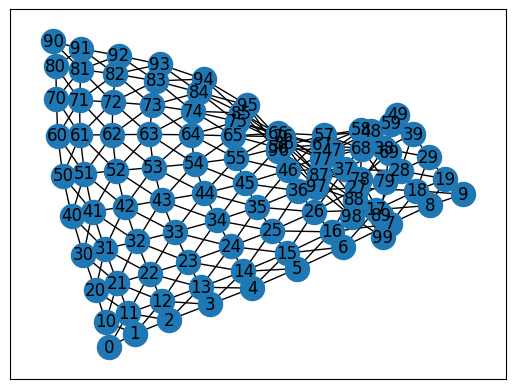

In [7]:
# print nodes
print(world.nodes())

# visualize the world map (grid) with its edges
nx.draw_networkx(world, with_labels=True)

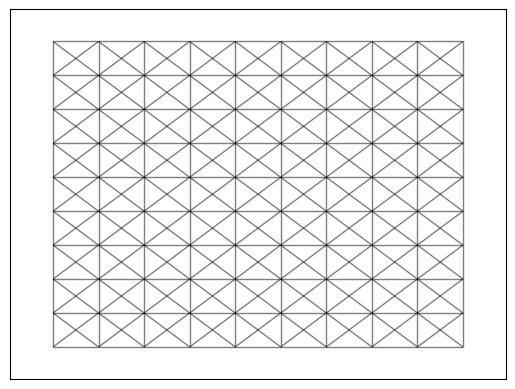

In [8]:
# draw just edges
pos = nx.get_node_attributes(world, 'pos')
edges = nx.draw_networkx_edges(world, pos, width=1.0, alpha=0.5)

#### 1.3 Calculate Manhatan Distance

In [9]:
# we pass two nodes' positions as a tuple and calculate the manhatan d.
def manhatan(pos1, pos2):
    return (abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1]))

#### 1.3 Define frontier:
Frontier for BFS will be a queue sturcture which will be holding all positions on the circle

In [10]:
# Define Start and the Goal node number
start = 5
goal = 66

# instead of Queue we use PriorityQueue
frontier = PriorityQueue()

# add start node to the frontier 
frontier.put((0, start)) # must pass a tuple (cost, node)

# create a visited dictionary where we can also save the parent node. 
# The goal is to keep track of visited node and make sure 
# we won't visit the same node again 
visited = dict() # visited[child]= parent
visited[start] = None # start node does not have any parent

# Since we need to take into account the cost (or weight of each path)
# so we create a dictionary to keep track of cost up to each node in the path
totalCost = dict()
totalCost[start] = 0

# we take one node at a time from frontier and 
# check all the neighbors and add them to both frontier and visited
while not frontier.empty():
    parent = frontier.get()[1] # from the tuple gives me the node number
    
    # if we reach the goal get out of loop
    if parent == goal:
        break
    
    for child in world.neighbors(parent):
        cost = totalCost[parent] + world.edges[parent, child]['weight']
        if child not in totalCost or cost < totalCost[child]:
            totalCost[child] = cost
            priority = cost 
            + manhatan(world.nodes[goal]['pos'], world.nodes[child]['pos'],)
            frontier.put((priority, child))
            visited[child] = parent

#### 1.4 Build the path:
By going backwards from the goal and finding the parents of the nodes we can build the path

In [11]:
current = goal
path = []
while current != start:
    path.append(current)
    current = visited[current]
path.append(start)
path.reverse()
print(path)

[5, 15, 25, 36, 46, 56, 66]


#### 1.5 Plot the path:

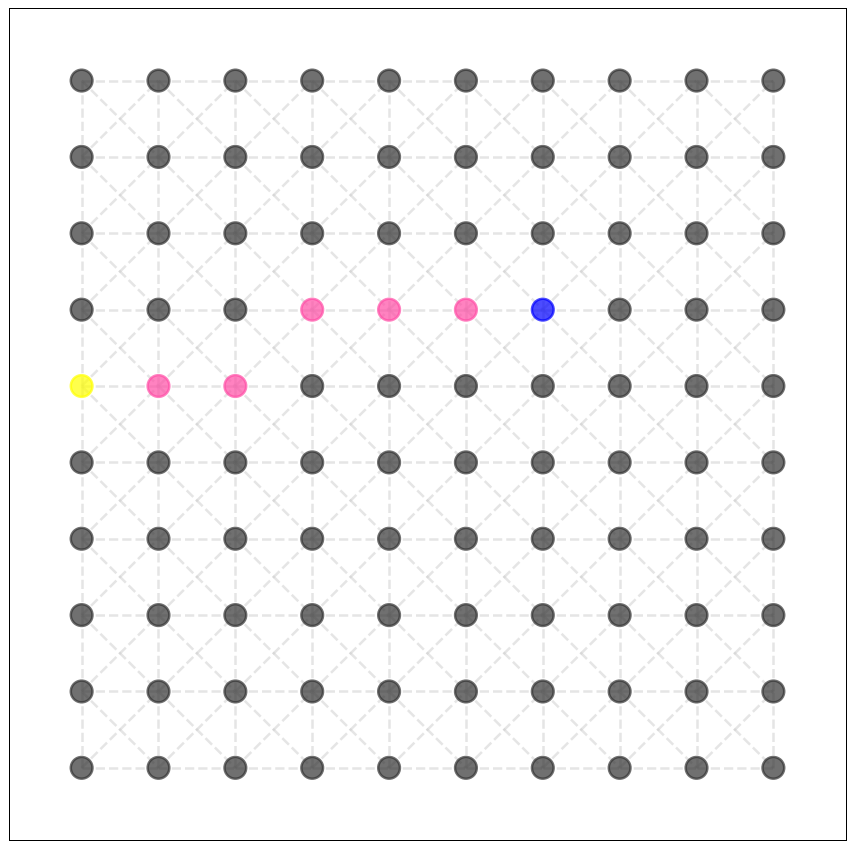

In [12]:
# Plotting
# flatten = np.zeros((xGrid * yGrid, 3), dtype=int)
flatten = np.full((10 * 10, 3), [0.2,0.2,0.2])
for p in path:
    if(int(p) == start):
        flatten[int(p)] = [1, 1, 0] # yellow node = start
    elif(int(p) == goal):
        flatten[int(p)] = [0, 0, 1] # blue node = goal
    else:
        flatten[int(p)] = [1, 0.3, 0.65] # pink nodes = path

colors = []
for f in flatten:
    colors.append(f)

# pos = nx.get_node_attributes(world, 'pos')
fig = plt.figure(1, figsize=(12, 12), dpi=90)
ax = fig.add_subplot(111)
nx.draw_networkx_nodes(world, pos, node_color=colors, node_size=300, alpha=0.7,
                       linewidths=2)
nx.draw_networkx_edges(world, pos, width=2, alpha=0.5, edge_color='#cccccc', style='dashed')
# labels = nx.get_edge_attributes(world, 'weight')
# nx.draw_networkx_edge_labels(world, pos, edge_labels=labels)
plt.savefig("AStar.png")
plt.show()